In [64]:
from datetime import datetime, timedelta,date
import pandas as pd
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division
from sklearn.cluster import KMeans

In [65]:
# !pip install chart-studio

In [66]:
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

In [67]:
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [68]:
import xgboost as xgb

In [69]:
tx_data = pd.read_csv("OnlineRetail.csv",  encoding="latin1")
tx_data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [70]:
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])

In [71]:
tx_data['InvoiceDate'].describe()

count                           541909
mean     2011-07-04 13:34:57.156386048
min                2010-12-01 08:26:00
25%                2011-03-28 11:34:00
50%                2011-07-19 17:17:00
75%                2011-10-19 11:27:00
max                2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [72]:
data_type = tx_data['InvoiceDate'].dtype
print("Data type of the column:", data_type)

Data type of the column: datetime64[ns]


In [73]:
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)

In [74]:
# Convert Python date objects to Pandas Timestamp objects
start_date = pd.Timestamp(date(2011, 3, 1))
end_date = pd.Timestamp(date(2011, 6, 1))

In [75]:
# Use the converted Timestamp objects for comparison
tx_3m = tx_uk[(tx_uk.InvoiceDate < end_date) & (tx_uk.InvoiceDate >= start_date)].reset_index(drop=True)

In [76]:
tx_3m['CustomerID'].count()

71683

In [77]:
tx_6m = tx_uk[(tx_uk.InvoiceDate >= date(2011,6,1)) & (tx_uk.InvoiceDate < date(2011,12,1))].reset_index(drop=True)

TypeError: Invalid comparison between dtype=datetime64[ns] and date

In [78]:
start_date_2 = pd.Timestamp(date(2011,6,1))
end_date_2 = pd.Timestamp(date(2011, 12, 1))

In [79]:
tx_6m = tx_uk[(tx_uk.InvoiceDate >= start_date_2) & (tx_uk.InvoiceDate < end_date_2)].reset_index(drop=True)

In [80]:
tx_6m['CustomerID'].count()

212734

In [81]:
tx_3m['InvoiceDate'].describe()

count                            95193
mean     2011-04-15 21:47:37.643313920
min                2011-03-01 08:30:00
25%                2011-03-24 09:50:00
50%                2011-04-15 10:37:00
75%                2011-05-10 11:44:00
max                2011-05-31 15:53:00
Name: InvoiceDate, dtype: object

In [82]:
tx_user = pd.DataFrame(tx_3m['CustomerID'].unique())
tx_user.columns = ['CustomerID']

In [83]:
tx_user['CustomerID'].count()

1840

Recency

In [84]:
tx_max_purchase = tx_3m.groupby('CustomerID').InvoiceDate.max().reset_index()

In [85]:
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [86]:
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

In [87]:
tx_max_purchase['MaxPurchaseDate'].max()

Timestamp('2011-05-31 15:32:00')

In [88]:
tx_max_purchase['Recency']

0        6
1        0
2        7
3       21
4       62
        ..
1835    20
1836    65
1837    85
1838     8
1839     9
Name: Recency, Length: 1840, dtype: int64

In [89]:
tx_max_purchase['Recency'][3]

21

In [90]:
tx_max_purchase['MaxPurchaseDate'][3]

Timestamp('2011-05-09 15:51:00')

In [91]:
tx_max_purchase['MaxPurchaseDate'][1]

Timestamp('2011-05-31 12:50:00')

In [92]:
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

In [93]:
tx_user.head()

,CustomerID,Recency
0,14620.0,12
1,14740.0,4
2,13880.0,25
3,16462.0,91
4,17068.0,11


In [94]:
tx_max_purchase.head()

,CustomerID,MaxPurchaseDate,Recency
0,12747.0,2011-05-25 09:57:00,6
1,12748.0,2011-05-31 12:50:00,0
2,12749.0,2011-05-23 17:08:00,7
3,12821.0,2011-05-09 15:51:00,21
4,12823.0,2011-03-30 10:36:00,62


In [95]:
tx_user.describe()

,CustomerID,Recency
count,1840.000000,1840.000000
mean,15534.587500,35.145652
std,1577.266588,26.231112
min,12747.000000,0.000000
25%,14197.250000,12.000000
50%,15554.500000,26.000000
75%,16841.500000,56.000000
max,18287.000000,91.000000


In [96]:
import plotly.graph_objects as go

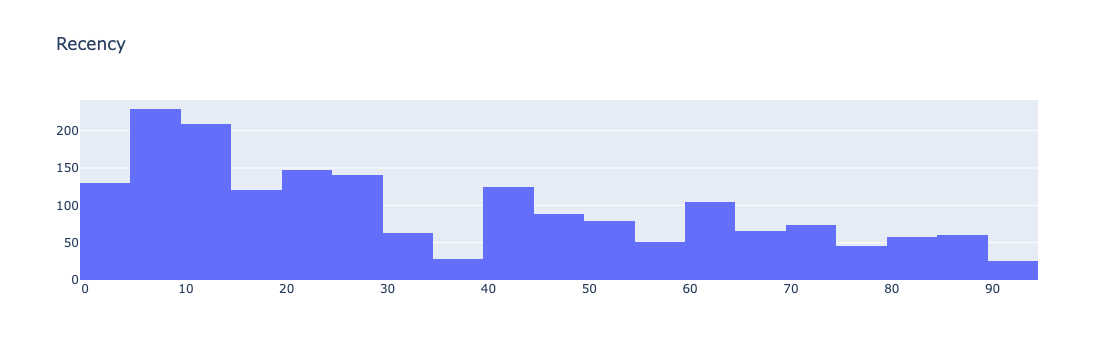

In [97]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define plot data
plot_data = [
    go.Histogram(
        x=tx_user['Recency']
    )
]

# Define plot layout
plot_layout = go.Layout(
    title='Recency'
)

# Create a figure using make_subplots for compatibility with Google Colab
fig = make_subplots(rows=1, cols=1)

# Add histogram trace to the figure
for trace in plot_data:
    fig.add_trace(trace)

# Update layout
fig.update_layout(title='Recency')

# Display the plot in Colab using fig.show()
fig.show()


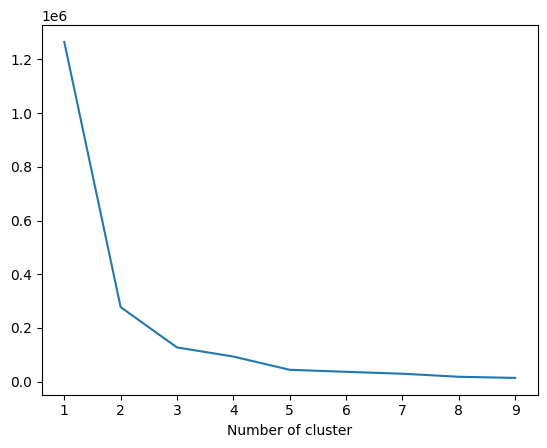

In [98]:
sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [99]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

In [100]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,608.0,8.312500,4.404323,0.0,5.0,8.0,12.0,16.0
1,461.0,50.687636,7.792837,39.0,43.0,50.0,57.0,64.0
2,444.0,24.373874,4.959870,17.0,20.0,23.0,27.0,35.0
3,327.0,77.752294,7.929702,65.0,70.0,76.0,85.0,91.0


In [101]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [102]:
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

Frequency

In [103]:
tx_frequency = tx_3m.groupby('CustomerID').InvoiceDate.count().reset_index()

In [104]:
tx_frequency.columns = ['CustomerID','Frequency']

In [105]:
tx_frequency.head()

,CustomerID,Frequency
0,12747.0,35
1,12748.0,582
2,12749.0,54
3,12821.0,6
4,12823.0,1


In [106]:
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

In [107]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,14620.0,12,3,30
1,14740.0,4,3,89
2,13880.0,25,2,38
3,16462.0,91,0,1
4,17068.0,11,3,76


In [108]:
tx_user.Frequency.describe()

count    1840.000000
mean       38.958152
std        60.968929
min         1.000000
25%        12.000000
50%        23.000000
75%        47.000000
max      1364.000000
Name: Frequency, dtype: float64

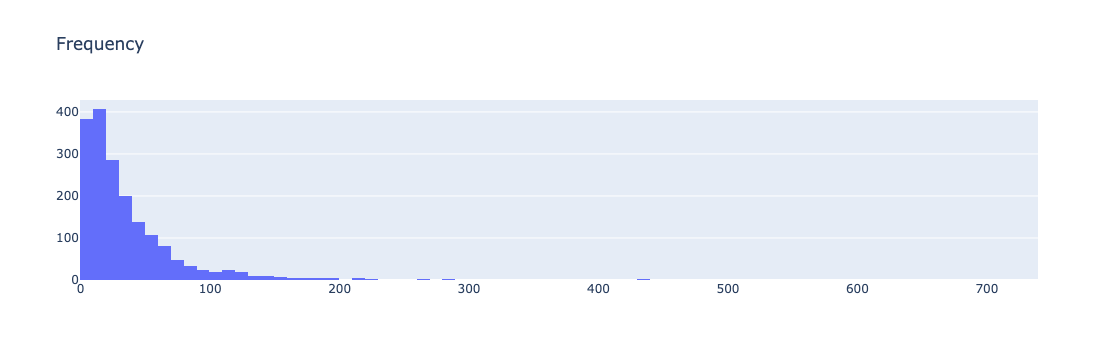

In [109]:
plot_data = [
    go.Histogram(
        x=tx_user.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

/var/folders/7_/9vnvvfzj5tx88k8dcbxpfvpc0000gn/T/ipykernel_40491/4002409087.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7_/9vnvvfzj5tx88k8dcbxpfvpc0000gn/T/ipykernel_40491/4002409087.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7_/9vnvvfzj5tx88k8dcbxpfvpc0000gn/T/ipykernel_40491/4002409087.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

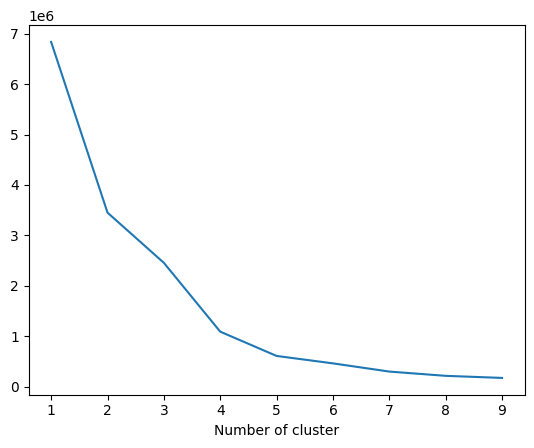

In [110]:
sse={}
tx_frequency = tx_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    tx_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [111]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

In [112]:
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,228.0,115.539474,43.867273,70.0,82.0,103.5,130.25,285.0
1,1600.0,24.075000,17.603886,1.0,10.0,20.0,35.00,69.0
2,11.0,496.000000,125.912668,331.0,422.5,452.0,570.00,730.0
3,1.0,1364.000000,NaN,1364.0,1364.0,1364.0,1364.00,1364.0


In [113]:
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

Monetary Value

In [114]:
tx_3m['Revenue'] = tx_3m['UnitPrice'] * tx_3m['Quantity']

In [115]:
tx_revenue = tx_3m.groupby('CustomerID').Revenue.sum().reset_index()

In [116]:
tx_revenue.head()

,CustomerID,Revenue
0,12747.0,1082.09
1,12748.0,4336.73
2,12749.0,782.10
3,12821.0,92.72
4,12823.0,459.00


In [117]:
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

In [118]:
tx_user.Revenue.describe()

count     1840.000000
mean       738.715017
std       1640.430156
min      -1462.500000
25%        210.237500
50%        369.825000
75%        749.490000
max      35085.480000
Name: Revenue, dtype: float64

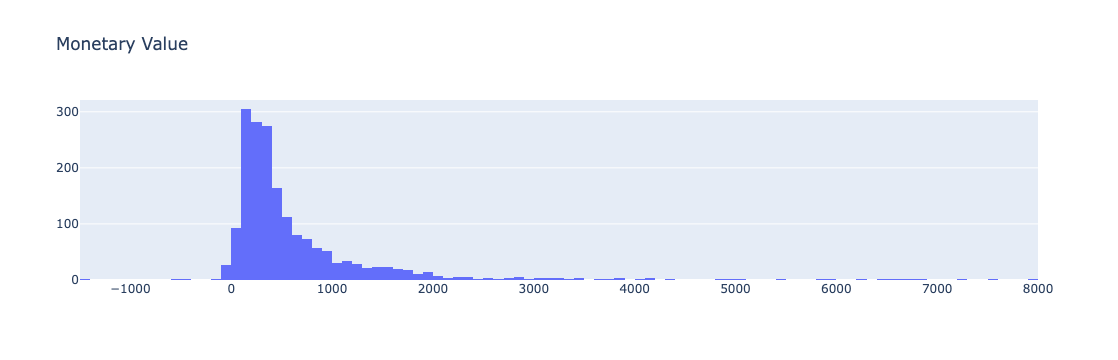

In [119]:
plot_data = [
    go.Histogram(
        x=tx_user.query('Revenue < 10000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Monetary Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [120]:
import warnings
warnings.filterwarnings("ignore")

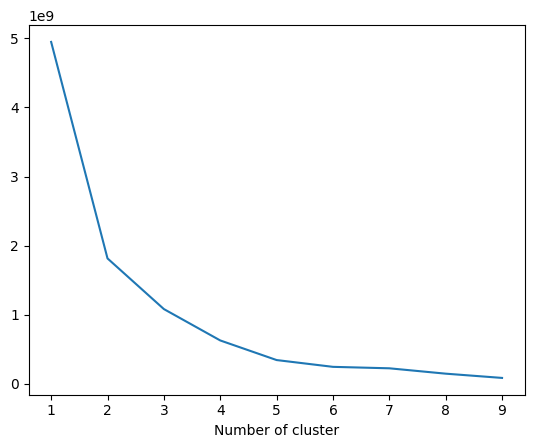

In [121]:
sse={}
tx_revenue = tx_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [122]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])

In [123]:
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

In [124]:
tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,1555.0,375.771389,259.854900,-1462.50,184.5750,313.77,515.5850,1093.65
1,256.0,1823.683754,718.276465,1104.41,1309.3100,1586.43,2028.4175,4336.73
2,21.0,7129.135714,2077.333582,4867.90,5837.7400,6583.80,7566.2000,11757.87
3,8.0,19792.028750,7151.059230,14984.73,15493.8425,16808.57,19803.9325,35085.48


In [125]:
tx_user.groupby('RevenueCluster')['Revenue'].max()

RevenueCluster
0     1093.65
1     4336.73
2    11757.87
3    35085.48
Name: Revenue, dtype: float64

Overall Segmentation

In [126]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,14620.0,12,3,30,0,393.28,0
1,14740.0,4,3,89,1,1448.21,1
2,13880.0,25,2,38,0,718.63,0
3,16462.0,91,0,1,0,34.00,0
4,17068.0,11,3,76,1,1480.95,1


In [127]:
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']

In [128]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore
0,14620.0,12,3,30,0,393.28,0,3
1,14740.0,4,3,89,1,1448.21,1,5
2,13880.0,25,2,38,0,718.63,0,2
3,16462.0,91,0,1,0,34.00,0,0
4,17068.0,11,3,76,1,1480.95,1,5


In [129]:
tx_user.groupby('OverallScore')[['Recency', 'Frequency', 'Revenue']].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,77.750820,17.393443,255.998033
1,52.006961,23.791183,352.175151
2,27.456576,30.007444,456.154715
3,11.633929,33.352679,548.886585
4,10.814815,77.096296,1611.609711
5,6.826087,111.369565,2381.006630
6,5.647059,249.352941,9066.467647
7,10.571429,330.000000,12370.358571
8,2.000000,943.000000,11147.410000


In [130]:
tx_user.groupby('OverallScore')['Recency'].count()

OverallScore
0    305
1    431
2    403
3    448
4    135
5     92
6     17
7      7
8      2
Name: Recency, dtype: int64

In [131]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value'
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value'

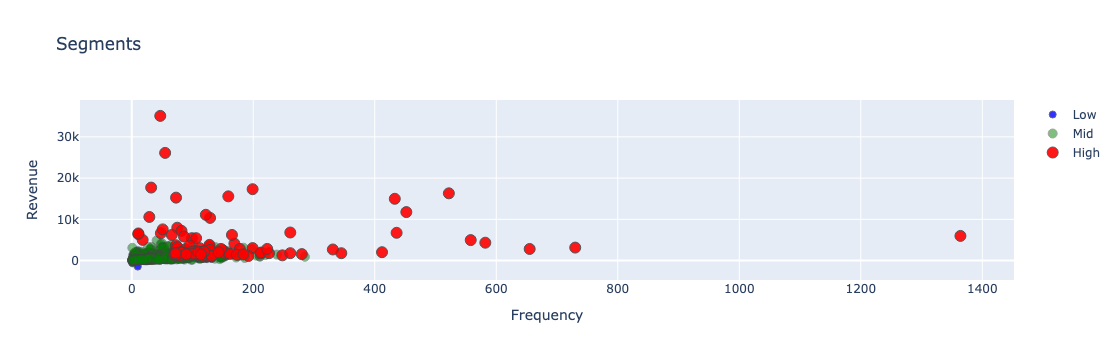

In [132]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

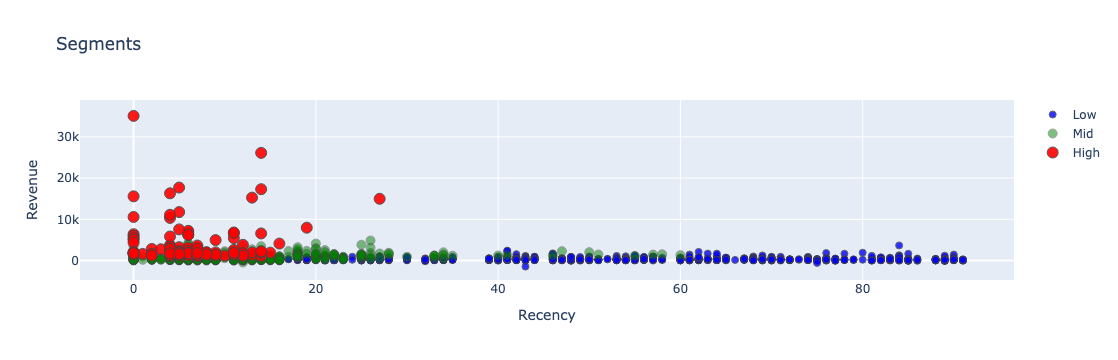

In [133]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

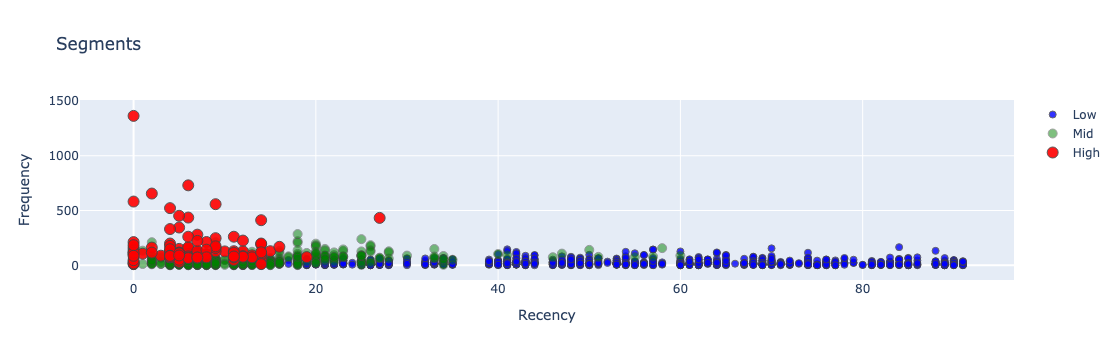

In [134]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

LTV

In [135]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value
1,14740.0,4,3,89,1,1448.21,1,5,High-Value
2,13880.0,25,2,38,0,718.63,0,2,Low-Value
3,16462.0,91,0,1,0,34.00,0,0,Low-Value
4,17068.0,11,3,76,1,1480.95,1,5,High-Value


In [136]:
tx_6m.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,555156,23299,FOOD COVER WITH BEADS SET 2,6,2011-06-01 07:37:00,3.75,15643.0,United Kingdom
1,555156,22847,BREAD BIN DINER STYLE IVORY,1,2011-06-01 07:37:00,16.95,15643.0,United Kingdom
2,555157,23075,PARLOUR CERAMIC WALL HOOK,16,2011-06-01 07:38:00,4.15,15643.0,United Kingdom
3,555157,47590B,PINK HAPPY BIRTHDAY BUNTING,6,2011-06-01 07:38:00,5.45,15643.0,United Kingdom
4,555157,22423,REGENCY CAKESTAND 3 TIER,4,2011-06-01 07:38:00,12.75,15643.0,United Kingdom


In [137]:
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']

In [138]:
tx_user_6m = tx_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
tx_user_6m.columns = ['CustomerID','m6_Revenue']

In [139]:
tx_user_6m.head()

,CustomerID,m6_Revenue
0,12747.0,1666.11
1,12748.0,18679.01
2,12749.0,2323.04
3,12820.0,561.53
4,12822.0,918.98


In [140]:
tx_6m.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,555156,23299,FOOD COVER WITH BEADS SET 2,6,2011-06-01 07:37:00,3.75,15643.0,United Kingdom,22.50
1,555156,22847,BREAD BIN DINER STYLE IVORY,1,2011-06-01 07:37:00,16.95,15643.0,United Kingdom,16.95
2,555157,23075,PARLOUR CERAMIC WALL HOOK,16,2011-06-01 07:38:00,4.15,15643.0,United Kingdom,66.40
3,555157,47590B,PINK HAPPY BIRTHDAY BUNTING,6,2011-06-01 07:38:00,5.45,15643.0,United Kingdom,32.70
4,555157,22423,REGENCY CAKESTAND 3 TIER,4,2011-06-01 07:38:00,12.75,15643.0,United Kingdom,51.00


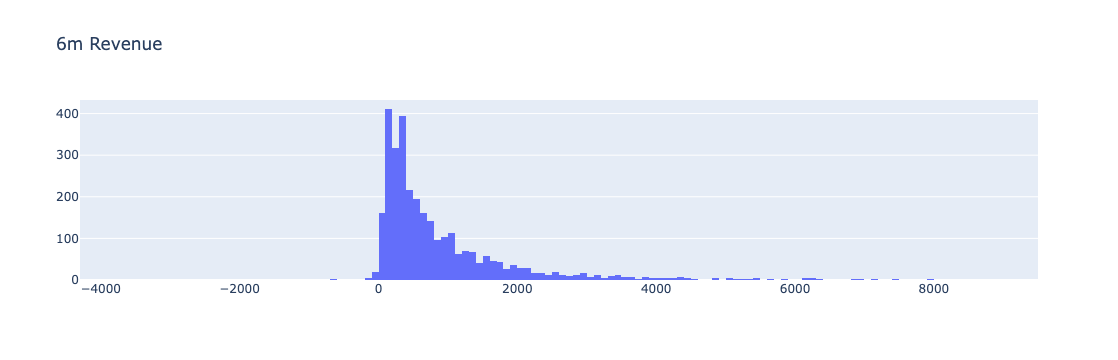

In [141]:
plot_data = [
    go.Histogram(
        x=tx_user_6m.query('m6_Revenue < 10000')['m6_Revenue']
    )
]

plot_layout = go.Layout(
        title='6m Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [142]:
tx_merge = pd.merge(tx_user, tx_user_6m, on='CustomerID', how='left')

In [143]:
tx_merge.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,NaN
1,14740.0,4,3,89,1,1448.21,1,5,High-Value,-25.00
2,13880.0,25,2,38,0,718.63,0,2,Low-Value,2193.14
3,16462.0,91,0,1,0,34.00,0,0,Low-Value,68.00
4,17068.0,11,3,76,1,1480.95,1,5,High-Value,2195.24


In [144]:
count_nan = tx_merge['Segment'].isnull().sum()

In [145]:
count_nan

0

In [146]:
tx_user_count = len(tx_user)
tx_user_count

1840

In [147]:
tx_merge_count = len(tx_merge)

In [148]:
tx_merge_count

1840

In [149]:
tx_merge = tx_merge.fillna(0)

In [150]:
tx_merge.groupby('Segment')['m6_Revenue'].mean()

Segment
High-Value    9371.865169
Low-Value      649.925320
Mid-Value     1495.147309
Name: m6_Revenue, dtype: float64

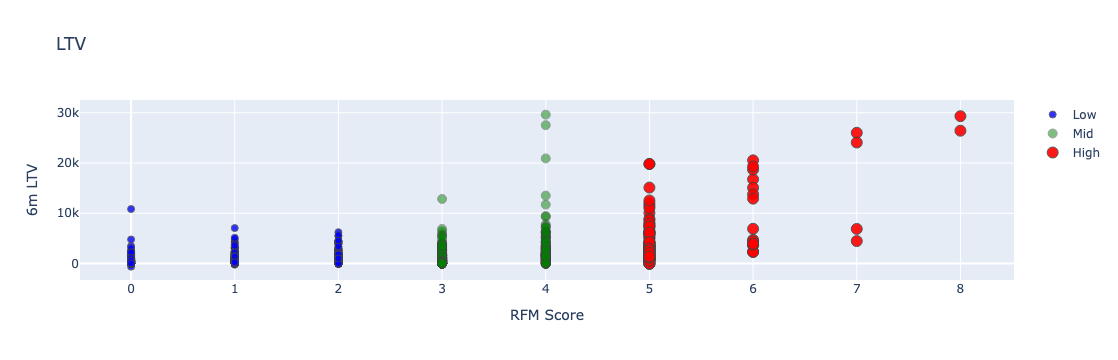

In [151]:
tx_graph = tx_merge.query("m6_Revenue < 30000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Low-Value'")['m6_Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Mid-Value'")['m6_Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'High-Value'")['m6_Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "6m LTV"},
        xaxis= {'title': "RFM Score"},
        title='LTV'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [152]:
tx_merge = tx_merge[tx_merge['m6_Revenue']<tx_merge['m6_Revenue'].quantile(0.99)]

In [153]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_merge[['m6_Revenue']])
tx_merge['LTVCluster'] = kmeans.predict(tx_merge[['m6_Revenue']])

In [154]:
tx_merge = order_cluster('LTVCluster', 'm6_Revenue',tx_merge,True)

In [155]:
tx_merge.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,1394.0,396.137189,419.891843,-609.40,0.000,294.220,682.4300,1429.87
1,371.0,2492.794933,937.341566,1445.31,1731.980,2162.930,3041.9550,5287.39
2,56.0,8222.565893,2983.572030,5396.44,6151.435,6986.545,9607.3225,16756.31


In [156]:
tx_cluster = tx_merge.copy()

In [157]:
tx_cluster.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,0.00,0
1,14740.0,4,3,89,1,1448.21,1,5,High-Value,-25.00,0
2,13880.0,25,2,38,0,718.63,0,2,Low-Value,2193.14,1
3,16462.0,91,0,1,0,34.00,0,0,Low-Value,68.00,0
4,17068.0,11,3,76,1,1480.95,1,5,High-Value,2195.24,1


In [158]:
tx_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,1394.0,396.137189,419.891843,-609.40,0.000,294.220,682.4300,1429.87
1,371.0,2492.794933,937.341566,1445.31,1731.980,2162.930,3041.9550,5287.39
2,56.0,8222.565893,2983.572030,5396.44,6151.435,6986.545,9607.3225,16756.31


In [159]:
tx_class = pd.get_dummies(tx_cluster)

In [160]:
tx_class.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,m6_Revenue,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,14620.0,12,3,30,0,393.28,0,3,0.00,0,False,False,True
1,14740.0,4,3,89,1,1448.21,1,5,-25.00,0,True,False,False
2,13880.0,25,2,38,0,718.63,0,2,2193.14,1,False,True,False
3,16462.0,91,0,1,0,34.00,0,0,68.00,0,False,True,False
4,17068.0,11,3,76,1,1480.95,1,5,2195.24,1,True,False,False


In [161]:
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
m6_Revenue            0.845933
Revenue               0.600491
RevenueCluster        0.543680
OverallScore          0.418183
Segment_High-Value    0.378779
FrequencyCluster      0.362247
Frequency             0.359601
RecencyCluster        0.235952
Segment_Mid-Value     0.126753
CustomerID           -0.028401
Recency              -0.237249
Segment_Low-Value    -0.302741
Name: LTVCluster, dtype: float64

In [162]:
X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [164]:
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.90
Accuracy of XGB classifier on test set: 0.82


In [165]:
tx_class.groupby('LTVCluster').CustomerID.count()/tx_class.CustomerID.count()

LTVCluster
0    0.765513
1    0.203734
2    0.030752
Name: CustomerID, dtype: float64

In [166]:
y_pred = ltv_xgb_model.predict(X_test)